In [1]:
import pandas as pd
import numpy as np
import math

# Mount to google drive
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir(r'/content/drive/My Drive/Colab Notebooks/ids705/project')

# from ydata_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import re

import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive/


# EDA

## possible feature engineering
- combine `longitude` and `latitude` by haversine since either of them alone could represent location
- `reviews_per month` has too many missing values and most of them are zero (i.e., no reviews), consider to **drop**
- `property_type` and `room_type` has similarities
- response variables is somewhat evenly distributed among bins
- calculated_... can use with room_type, property_type to determine the house type
- bathroom_text can be represented by room_type, maybe I can calculate % accomendates vs. bathroom#
- availability concatenates to 1 variable
- `has_review` indicates whether or not it has reviews
- investigate `amenities` and `reviews`

## variables considered to include

host_acceptance_rate, haversine_location, accomendates,

In [2]:
data = pd.read_csv("data/chicago_listings_cleaned.csv")
# test = pd.read_csv("data/test.csv")
# data = pd.concat([train, test]).reset_index(drop=True)
# Split to train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [3]:
# Access profile report
# profile = ProfileReport(train, title="profile_report")
# profile.to_file("profile_report.pdf")

In [4]:
# prompt: show which columns are missing values in data

# Identify columns with missing values
missing_cols = train.columns[train.isnull().any()]

# Print the columns with missing values
missing_cols


Index(['description', 'neighbourhood_group_cleansed', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'has_availability',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [5]:
test.columns

Index(['name', 'description', 'property_type', 'price',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'instant_bookable',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'rev

In [6]:
train.shape

(6998, 51)

## text variables

### amenities

In [7]:
# amenities
## clean
import ast
freq_words = ['you', 'on', 'and', 'the', 'or', 'n', 'for', 'with', 'in', 'at']

def clean_amenities(amenities_str):
    try:
        amenities_lst = ast.literal_eval(amenities_str)
    except:
        amenities_lst = []
    amenities_clean = []
    for amenity in amenities_lst:
        # remove special characters and extra spaces
        # e.g., Wi-Fi vs. wifi
        amenity_clean = re.sub(r'[^A-Za-z0-9\s]', '', amenity.lower().strip())
        # Remove freq_words using regex
        pattern = r'\b(?:' + '|'.join(re.escape(word) for word in freq_words) + r')\b'
        amenity_clean = re.sub(pattern, '', amenity_clean)
        # turn air conditioning to ac
        amenity_clean = amenity_clean.replace('air conditioning', 'ac')
        # Remove extra spaces
        amenity_clean = re.sub(r'\s+', ' ', amenity_clean).strip()
        amenities_clean.append(amenity_clean)
    return amenities_clean

train['amenities_clean'] = train['amenities'].apply(clean_amenities)
test['amenities_clean'] = test['amenities'].apply(clean_amenities)
print(train['amenities_clean'])

# amenities count
train['amenities_cnt'] = train['amenities_clean'].apply(lambda x: len(x))
test['amenities_cnt'] = test['amenities_clean'].apply(lambda x: len(x))


0       [building staff, dedicated workspace, heating,...
1       [building staff, dedicated workspace, gym, hea...
2       [roomdarkening shades, hot water kettle, ceili...
3       [ac, hot water, bed linens, exterior security ...
4       [dishes silverware, hot water, self checkin, d...
                              ...                        
6993    [heating, carbon monoxide alarm, lockbox, fire...
6994    [carbon monoxide alarm, fire extinguisher, fir...
6995    [dishes silverware, central heating, record pl...
6996    [dishes silverware, dedicated workspace, gym, ...
6997    [ac, beach access beachfront, first aid kit, w...
Name: amenities_clean, Length: 6998, dtype: object


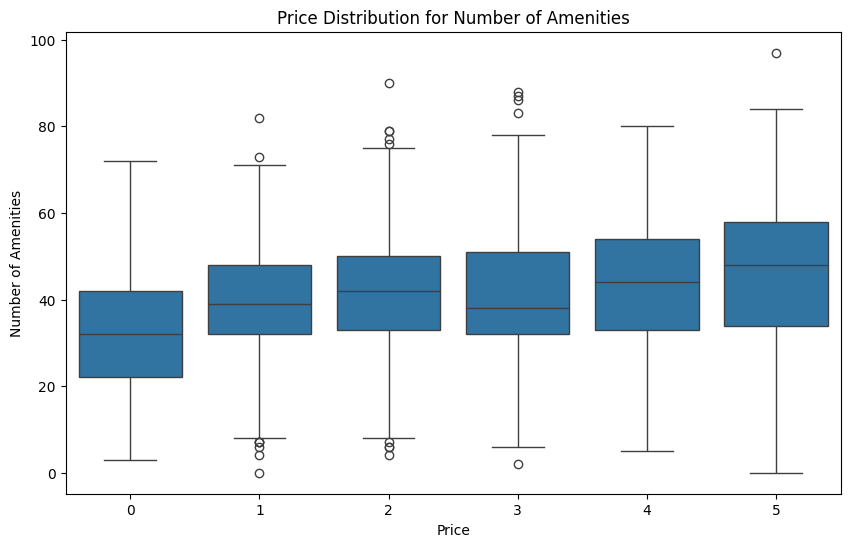

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='price', y='amenities_cnt', data=train)
plt.title('Price Distribution for Number of Amenities')
plt.xlabel('Price')
plt.ylabel('Number of Amenities')
plt.show()

#### LDA
try topic modeling (but the clustering does not make sense)

In [10]:
# from sklearn.feature_extraction.text import CountVectorizer

# # Join amenities into a single string per listing
# train['amenities_str'] = train['amenities_clean'].apply(lambda x: ' '.join(x))
# test['amenities_str'] = test['amenities_clean'].apply(lambda x: ' '.join(x))

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import NMF
# from sklearn.decomposition import LatentDirichletAllocation

# # Use TF-IDF features
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_train = tfidf_vectorizer.fit_transform(train['amenities_str'])
# tfidf_test = tfidf_vectorizer.transform(test['amenities_str'])

# # Use count features
# vectorizer = CountVectorizer()
# dtm = vectorizer.fit_transform(train['amenities_str'])
# # filter out the count <= 30
# dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
# mask = ~dtm_df.columns.str.match(r'^\d+$')
# dtm_df = dtm_df.loc[:, mask]
# amenities_sum = dtm_df.sum(axis=0)
# dtm_df = dtm_df.loc[:, amenities_sum[amenities_sum>30].index.tolist()]
# filtered_amenities = dtm_df.columns.tolist()

# # convert to df
# tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out()).reindex(columns=filtered_amenities).fillna(0)
# tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out()).reindex(columns=filtered_amenities).fillna(0)

# # # Create the document-term matrix
# # # vectorizer = CountVectorizer()
# # # dtm = vectorizer.fit_transform(train['amenities_str'])

# # # remove infrequent features, remove numeric features
# # dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
# # dtm_test_df = pd.DataFrame(dtm_test.toarray(), columns=vectorizer.get_feature_names_out())

# mask = ~dtm_df.columns.str.match(r'^\d+$')
# dtm_df = dtm_df.loc[:, mask]
# dtm_test_df = dtm_test_df.loc[:, mask]

# amenities_sum = dtm_df.sum(axis=0)
# dtm_df = dtm_df.loc[:, amenities_sum[amenities_sum>30].index.tolist()]
# amenities_sum = dtm_test_df.sum(axis=0)
# dtm_test_df = dtm_test_df.loc[:, amenities_sum[amenities_sum>30].index.tolist()]
# # # drop unknown columns in test
# # dtm_test_df = dtm_test_df[dtm_test_df.columns.isin(dtm_df.columns)]

# columns_df1 = dtm_df.columns.tolist()

# Create a new DataFrame (filtered_df2) with the same columns as df1
# dtm_test_df = dtm_test_df.reindex(columns=columns_df1).fillna(0)

# put in NMF
# Fit the NMF model
# n_topics = 10
# topic_model = NMF(n_components=n_topics, random_state=42)
# # topic_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# amentities_topics_train = topic_model.fit_transform(tfidf_train_df)
# amenities_topics_train_df = pd.DataFrame(amentities_topics_train, columns=[f'amenity_topic_{i}' for i in range(n_topics)])
# amentities_topics_test = topic_model.transform(tfidf_test_df)
# amenities_topics_test_df = pd.DataFrame(amentities_topics_test, columns=[f'amenity_topic_{i}' for i in range(n_topics)])
# # Display the topics
# def display_topics(model, feature_names, num_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         message = f"Topic {topic_idx}: "
#         message += ", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]])
#         print(message)
# display_topics(topic_model, filtered_amenities, n_topics)


#### word2vec

In [11]:
# from gensim.models import Word2Vec

# # Prepare sentences (each listing's amenities as a sentence)
# sentences = data['amenities_clean'].tolist()

# # Train Word2Vec model
# w2v_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)

# # Get embeddings for amenities
# amenity_embeddings = {amenity: w2v_model.wv[amenity] for amenity in w2v_model.wv.index_to_key}

# # Cluster embeddings
# from sklearn.cluster import KMeans

# amenity_vectors = list(amenity_embeddings.values())
# kmeans = KMeans(n_clusters=7, random_state=42)
# kmeans.fit(amenity_vectors)

# # Map amenities to clusters
# amenity_to_cluster = dict(zip(amenity_embeddings.keys(), kmeans.labels_))


In [12]:
# amenity_to_cluster

#### manual mapping

In [13]:
amenity_topics = {
    "Kitchen Supplies": [
        "kettle", "coffee machine", "coffee maker", "microwave", "oven", "stove",
        "refrigerator", "dishwasher", "cooking basics", "pots", "pans", "dishes", "silverware",
        "toaster", "blender", "cooker", "fridge"
    ],
    "House Infrastructure": [
        "hot water", "ac", "heating", "dryer", "fireplace", "wifi", "crib",
        "ceiling fan", "iron", "hair dryer", "pillows", "blankets", "room-darkening shades",
        "essential toiletries", "private entrance"
    ],
    "Entertainment": [
        "tv", "streaming services", "game console", "books", "board games",
        "DVD player"
    ],
    "Safety Features": [
        "smoke alarm", "carbon monoxide alarm", "first aid kit", "fire extinguisher",
        "security cameras", "lock on bedroom door", "safe", "emergency exit", "fire blanket"
    ],
    "Outdoor Amenities": [
        "balcony", "patio", "garden", "backyard", "bbq", "outdoor",
        "beach access", "lake access", "hammock", "rooftop"
    ],
    "Luxury Amenities": [
        "tub", "pool", "sauna", "gym", "jacuzzi", "spa", "wine cooler", "dyson", "bosche", "sound system",
        "butler service", "massage", "heated floors", "fitness", "yoga", "piano", "record player", "karaoke machine"
    ],
    "Family-Friendly Amenities": [
        "children's books and toys", "baby", "pet",
        "stroller", "babysitter", "pet"
    ]
}

def map_amenities_to_topics(amenities_list):
    topic_counts = {topic: 0 for topic in amenity_topics.keys()}
    for amenity in amenities_list:
        for topic, amenities in amenity_topics.items():
            if amenity in amenities:
                topic_counts[topic] += 1
    return topic_counts

train['topics_cnt_dict']= train['amenities_clean'].apply(map_amenities_to_topics)
test['topics_cnt_dict']= test['amenities_clean'].apply(map_amenities_to_topics)
train = pd.concat([train.drop('topics_cnt_dict', axis=1), pd.DataFrame(train['topics_cnt_dict'].tolist())], axis=1)
test = pd.concat([test.drop('topics_cnt_dict', axis=1), pd.DataFrame(test['topics_cnt_dict'].tolist())], axis=1)


## description

In [14]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.hist(train.loc[train['description'].isna(), 'price'], bins=6, edgecolor='black')
# plt.title('Price Distribution for Listings with No Description')
# plt.xlabel('Price')
# plt.ylabel('Frequency')
# plt.show()

In [15]:
def clean_description(des):

    pattern = r'[-&]|\b(and|or)\b'

    if des is np.nan:
        des = ''
    else:
        des = re.sub(pattern, '', des, flags=re.IGNORECASE).lower().strip()

    return des

train['description_clean'] = train['description'].apply(clean_description)
test['description_clean'] = test['description'].apply(clean_description)

train['des_len'] = train['description_clean'].apply(lambda x: len(x.split(' ')))
test['des_len'] = test['description_clean'].apply(lambda x: len(x.split(' ')))

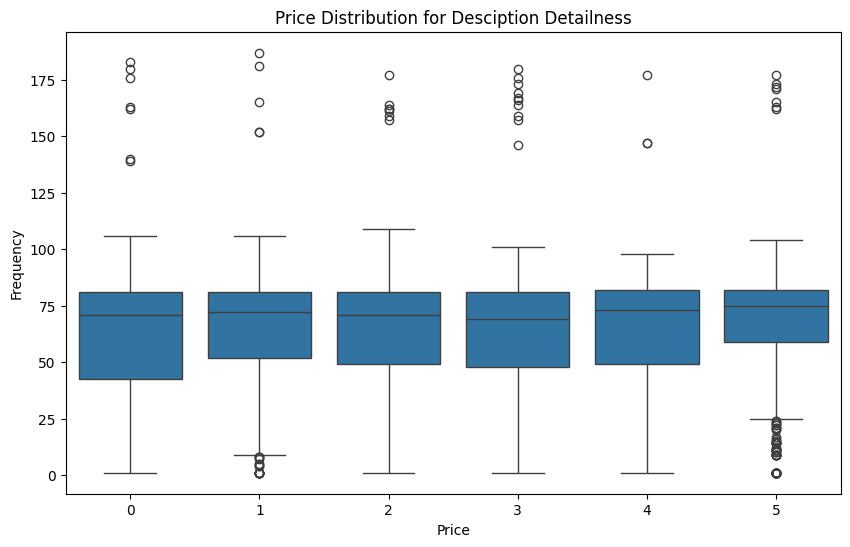

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='price', y='des_len', data=train)
plt.title('Price Distribution for Desciption Detailness')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

## categorical variables

In [17]:
# has_review
train['has_review'] = 1
test['has_review'] = 1

from sklearn.preprocessing import OrdinalEncoder

# label encoder neighbourhood_cleansed (217 distinct values)
oe_neighbourhood = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_neighbourhood.fit(train[['neighbourhood_cleansed']])

# Transform both training and test data
train['neighbourhood_cleansed_encoded'] = oe_neighbourhood.transform(train[['neighbourhood_cleansed']])
test['neighbourhood_cleansed_encoded'] = oe_neighbourhood.transform(test[['neighbourhood_cleansed']])

# label encoder neighbourhood_group_cleansed (* distinct values)
le_group = LabelEncoder()
train['neighbourhood_group_cleansed_encoded'] = le_group.fit_transform(train['neighbourhood_group_cleansed'])
train.drop(['neighbourhood_cleansed', 'neighbourhood_group_cleansed'], axis=1, inplace=True)

test['neighbourhood_group_cleansed_encoded'] = le_group.transform(test['neighbourhood_group_cleansed'])
test.drop(['neighbourhood_cleansed', 'neighbourhood_group_cleansed'], axis=1, inplace=True)

# room_type
enc = LabelEncoder()
train['room_type_encoded'] = enc.fit_transform(train['room_type'])
test['room_type_encoded'] = enc.transform(test['room_type'])

train.drop('room_type', axis=1, inplace=True)
test.drop('room_type', axis=1, inplace=True)

In [18]:
# property_type from 59 to 14
def organize_property_type(prop):

    prop = str(prop).lower()

    # rental
    if 'rental' in prop:

        return 'rental'

    # townhouse, bungalow
    if ('townhouse' in prop) or ('cottage' in prop):

        return 'townhouse'

    if ('bungalow' in prop) or ('villa' in prop) or ('vacation' in prop):

        return 'villa'

    if 'service' in prop:

        return 'serviced'

    # condo
    if 'condo' in prop:

        return 'condo'

    if 'loft' in prop:

        return 'loft'

    if 'hostel' in prop:

        return 'hostel'

    if ('homestay' in prop) or ('breakfast' in prop) or ('casa' in prop):

        return 'homestay'

    if 'tiny' in prop:

        return 'tiny'

    if 'guest' in prop:

        return 'guesthouse'

    if 'camper' in prop:

        return 'camper'

    if ('home' in prop) or ('entire place' in prop):

        return 'home'

    if ('hotel' in prop) or ('resort' in prop):

        return 'hotel'

    else:

        return 'others'

train['property_type_org'] = train['property_type'].apply(organize_property_type)
test['property_type_org'] = test['property_type'].apply(organize_property_type)

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train['property_type_encoded'] = enc.fit_transform(train[['property_type_org']])
test['property_type_encoded'] = enc.transform(test[['property_type_org']])

In [19]:
train['host_response_time'] = train['host_response_time'].fillna('unknown')
test['host_response_time'] = test['host_response_time'].fillna('unknown')

enc = LabelEncoder()
train['host_response_time_encoded'] = enc.fit_transform(train['host_response_time'])
test['host_response_time_encoded'] = enc.transform(test['host_response_time'])

In [20]:
# extract if the bathroom is shared
train['bathroom_shared'] = train['bathrooms_text'].apply(lambda x: 1 if (isinstance(x, str) and re.search('shared', x)) or (x == 0) else 0)
test['bathroom_shared'] = test['bathrooms_text'].apply(lambda x: 1 if (isinstance(x, str) and re.search('shared', x)) or (x == 0) else 0)
train.drop('bathrooms_text', axis=1, inplace=True)
test.drop('bathrooms_text', axis=1, inplace=True)

In [21]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False)
# encoder.fit(train[['room_type']])

# train_encoded = encoder.transform(train[['room_type']])
# test_encoded = encoder.transform(test[['room_type']])
# df_train = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out())
# df_test = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out())

# # integrate the encoded
# train = pd.concat([train, df_train], axis=1)
# test = pd.concat([test, df_test], axis=1)

In [22]:
# train.groupby('property_type').size().sort_values(ascending=False)

In [23]:
train.shape

(6998, 66)

## numerical variables

In [24]:
# How many years the host has been hosting from 2024
train['host_years'] = train['host_since'].apply(lambda x: 2024-int(x.split('-')[0]))
test['host_years'] = test['host_since'].apply(lambda x: 2024-int(x.split('-')[0]))

# from 2008 since aribnb founded, 2008 = year 0, when is the first_review and last_review
# fill NA with -1
train['first_review_recalculated'] = train['first_review'].apply(lambda x: int(x.split('-')[0]) - 2008 + int(x.split('-')[1]) / 12 if isinstance(x, str) else np.nan)
train['last_review_recalculated'] = train['last_review'].apply(lambda x: int(x.split('-')[0]) - 2008 + int(x.split('-')[1]) / 12 if isinstance(x, str) else np.nan)
test['first_review_recalculated'] = test['first_review'].apply(lambda x: int(x.split('-')[0]) - 2008 + int(x.split('-')[1]) / 12 if isinstance(x, str) else np.nan)
test['last_review_recalculated'] = test['last_review'].apply(lambda x: int(x.split('-')[0]) - 2008 + int(x.split('-')[1]) / 12 if isinstance(x, str) else np.nan)

In [25]:
train['bathrooms'] = train['bathrooms'].fillna(0)
test['bathrooms'] = test['bathrooms'].fillna(0)

train['bathroom_per_accommodate'] = train['bathrooms'] / train['accommodates']
test['bathroom_per_accommodate'] = test['bathrooms'] / test['accommodates']

train['beds'] = train['beds'].fillna(0)
test['beds'] = test['beds'].fillna(0)

train['bed_per_accommodate'] = train['beds'] / train['accommodates']
test['bed_per_accommodate'] = test['beds'] / test['accommodates']

In [26]:
train['availability_90_ratio'] = train['availability_90']/90
test['availability_90_ratio'] = test['availability_90']/90

train['availability_30_60'] = train.apply(lambda row: row['availability_30'] / row['availability_60'] if row['availability_60']!=0 else 0, axis=1)
test['availability_30_60'] = test.apply(lambda row: row['availability_30'] / row['availability_60'] if row['availability_60']!=0 else 0, axis=1)

In [27]:
train['host_is_superhost']

,host_is_superhost
0,False
1,False
2,True
3,False
4,False
...,...
6993,False
6994,False
6995,False
6996,False


In [28]:
# prompt: for train and test df, convert all f in host_is_superhost to 0, and t to 1

# Convert 'f' to 0 and 't' to 1 in 'host_is_superhost' column for train and test DataFrames
train['host_is_superhost'] = train['host_is_superhost'].map({'f': 0, 't': 1})
test['host_is_superhost'] = test['host_is_superhost'].map({'f': 0, 't': 1})


#### fill NA

In [29]:
# ---
# figure out how long the listing might be empty
from datetime import datetime
cur_date = pd.to_datetime('2024-11-01')
train['days_since_last_review'] = (cur_date - pd.to_datetime(train['last_review'])).dt.days
test['days_since_last_review'] = (cur_date - pd.to_datetime(test['last_review'])).dt.days

# ---
fill_zero_feat = ['host_is_superhost', 'beds', 'bathrooms', 'number_of_reviews_ltm']
for feat in fill_zero_feat:
    train[feat] = train[feat].fillna(0)
    test[feat] = test[feat].fillna(0)

# after filling with int 0, the original boolean value would result value error
# convert all to numeric
train['host_is_superhost'] = train['host_is_superhost'].apply(int)
test['host_is_superhost'] = test['host_is_superhost'].apply(int)

# ---
fill_mean_feat = ['host_response_rate', 'host_acceptance_rate', 'review_scores_rating', 'review_scores_accuracy',
                  'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'days_since_last_review',
                  'review_scores_location', 'review_scores_value', 'reviews_per_month', 'first_review_recalculated', 'last_review_recalculated']
for feat in fill_mean_feat:

    mean_val = train[feat].mean()
    train[feat] = train[feat].fillna(mean_val)
    test[feat] = test[feat].fillna(mean_val)

# ---
# dummy indicates if have reviews in the past year
train['has_reviews_ltm'] = train['number_of_reviews_ltm'].apply(lambda x: 1 if x!=0 else 0)
test['has_reviews_ltm'] = test['number_of_reviews_ltm'].apply(lambda x: 1 if x!=0 else 0)

In [30]:
# how many reviews per month in the recent year
train['reviews_per_month_ltm'] = train['number_of_reviews_ltm'] / 12
test['reviews_per_month_ltm'] = test['number_of_reviews_ltm'] / 12

In [31]:
missing_values = train.isnull().sum()
missing_values[missing_values > 0]

,0
description,134
bedrooms,136
has_availability,86
first_review,1491
last_review,1491


In [32]:
missing_values = test.isnull().sum()
missing_values[missing_values > 0]

,0
description,29
bedrooms,37
has_availability,13
first_review,387
last_review,387


#### One-hot encoding binerize variables

In [33]:
# # binerize number_of_reviews since a lot of 0s
# review_bins = [-1, 0, 10, 34, 166, 5000]
# review_labels = ['No reviews', '1-10 reviews', '11-34 reviews', '34-166 reviews', '166+ reviews']

# train['reviews_category'] = pd.cut(train['number_of_reviews'], bins=review_bins, labels=review_labels)
# test['reviews_category'] = pd.cut(test['number_of_reviews'], bins=review_bins, labels=review_labels)

# # one-hot encoding
# from sklearn.preprocessing import OneHotEncoder
# oe_reviews = OneHotEncoder(sparse_output=False)
# oe_reviews.fit(train[['reviews_category']])

# train_encoded = oe_reviews.transform(train[['reviews_category']])
# test_encoded = oe_reviews.transform(test[['reviews_category']])
# reviews_df_train = pd.DataFrame(train_encoded, columns=oe_reviews.get_feature_names_out())
# reviews_df_test = pd.DataFrame(test_encoded, columns=oe_reviews.get_feature_names_out())

# # integrate the encoded
# train = pd.concat([train, reviews_df_train, amenities_topics_train_df], axis=1)
# test = pd.concat([test, reviews_df_test, amenities_topics_test_df], axis=1)


# # binerize number_of_reviews since a lot of 0s
# response_bins = [-1, 0, 75, 100]
# response_labels = ['No response', 'less than 75 response', '75-100 response']

# train['host_response_rate'] = train['host_response_rate'].fillna(0)
# test['host_response_rate'] = test['host_response_rate'].fillna(0)
# train['response_category'] = pd.cut(train['host_response_rate'], bins=response_bins, labels=response_labels)
# test['response_category'] = pd.cut(test['host_response_rate'], bins=response_bins, labels=response_labels)

# # one-hot encoding
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False)
# encoder.fit(train[['response_category']])

# train_encoded = encoder.transform(train[['response_category']])
# test_encoded = encoder.transform(test[['response_category']])
# response_df_train = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out())
# response_df_test = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out())

# # integrate the encoded
# train = pd.concat([train, response_df_train], axis=1)
# test = pd.concat([test, response_df_test], axis=1)

In [34]:
# train['host_acceptance_rate'] = train['host_acceptance_rate'].fillna(-1)
# test['host_acceptance_rate'] = test['host_acceptance_rate'].fillna(-1)
# train['review_scores_rating'] = train['review_scores_rating'].fillna(0)
# test['review_scores_rating'] = test['review_scores_rating'].fillna(0)
# train['review_scores_rating'] = train['review_scores_rating'].fillna(0)
# test['review_scores_rating'] = test['review_scores_rating'].fillna(0)
# train['review_scores_accuracy'] = train['review_scores_accuracy'].fillna(0)
# test['review_scores_accuracy'] = test['review_scores_accuracy'].fillna(0)
# train['review_scores_cleanliness'] = train['review_scores_cleanliness'].fillna(0)
# test['review_scores_cleanliness'] = test['review_scores_cleanliness'].fillna(0)
# train['review_scores_cleanliness'] = train['review_scores_cleanliness'].fillna(0)
# test['review_scores_cleanliness'] = test['review_scores_cleanliness'].fillna(0)
# train['review_scores_checkin'] = train['review_scores_checkin'].fillna(0)
# test['review_scores_checkin'] = test['review_scores_checkin'].fillna(0)
# train['review_scores_communication'] = train['review_scores_communication'].fillna(0)
# test['review_scores_communication'] = test['review_scores_communication'].fillna(0)
# train['review_scores_location'] = train['review_scores_location'].fillna(0)
# test['review_scores_location'] = test['review_scores_location'].fillna(0)
# train['review_scores_value'] = train['review_scores_value'].fillna(0)
# test['review_scores_value'] = test['review_scores_value'].fillna(0)
# train['reviews_per_month'] = train['reviews_per_month'].fillna(-1)
# test['reviews_per_month'] = test['reviews_per_month'].fillna(-1)

In [35]:
# # Assume 'data' is your DataFrame containing 'longitude' and 'latitude'

# # Step 1: Determine data ranges
# min_longitude = train['longitude'].min()
# max_longitude = train['longitude'].max()
# min_latitude = train['latitude'].min()
# max_latitude = train['latitude'].max()

# # Step 2: Decide on the number of bins
# num_bins = 10  # Adjust as needed

# # Step 3: Create bin edges
# longitude_bins = np.linspace(min_longitude, max_longitude, num_bins + 1)
# latitude_bins = np.linspace(min_latitude, max_latitude, num_bins + 1)

# # Step 4: Assign to bins
# longitude_bin_indices = np.digitize(train['longitude'], longitude_bins) - 1
# latitude_bin_indices = np.digitize(train['latitude'], latitude_bins) - 1

# # Handle edge cases
# longitude_bin_indices[longitude_bin_indices == num_bins] = num_bins - 1
# latitude_bin_indices[latitude_bin_indices == num_bins] = num_bins - 1

# # Step 5: Combine bins to create geo categories
# train['geo_category'] = latitude_bin_indices * num_bins + longitude_bin_indices

# ##################################
# # Step 4: Assign to bins
# longitude_bin_indices = np.digitize(test['longitude'], longitude_bins) - 1
# latitude_bin_indices = np.digitize(test['latitude'], latitude_bins) - 1

# # Handle edge cases
# longitude_bin_indices[longitude_bin_indices == num_bins] = num_bins - 1
# latitude_bin_indices[latitude_bin_indices == num_bins] = num_bins - 1

# # Step 5: Combine bins to create geo categories
# test['geo_category'] = latitude_bin_indices * num_bins + longitude_bin_indices

# ##################################

# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(
#     train['longitude'],
#     train['latitude'],
#     c=train['geo_category'],
#     cmap='tab20',
#     s=10
# )
# plt.colorbar(scatter, label='Geo Category')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Geographical Categories of NYC Airbnb Listings')
# plt.show()

In [36]:
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(
#     test['longitude'],
#     test['latitude'],
#     c=test['geo_category'],
#     cmap='tab20',
#     s=10
# )
# plt.colorbar(scatter, label='Geo Category')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Geographical Categories of NYC Airbnb Listings')
# plt.show()

In [37]:
# np.unique(train['geo_category'])

# Feature Selection

In [38]:
train.columns

Index(['name', 'description', 'property_type', 'price', 'latitude',
       'longitude', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'amenities', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'instant_bookable', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores

In [39]:
features = ['latitude',
       'longitude', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count',
       'availability_90_ratio', 'instant_bookable',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'amenities_cnt', 'has_review',
       'neighbourhood_cleansed_encoded',
       'neighbourhood_group_cleansed_encoded', 'room_type_encoded',
       'bathroom_shared',
       # 'Kitchen Supplies',
       # 'House Infrastructure', 'Entertainment', 'Safety Features',
       # 'Outdoor Amenities', 'Luxury Amenities', 'Family-Friendly Amenities',
       'days_since_last_review', 'has_reviews_ltm', 'des_len',
       'bathroom_per_accommodate', 'bed_per_accommodate',
       'property_type_encoded', 'host_response_time_encoded', 'accommodates',
       'reviews_per_month_ltm', 'first_review_recalculated', 'last_review_recalculated',
       'availability_30_60']

In [40]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(train[features])
selected_features1 = [features[i] for i in range(len(features)) if selector.get_support()[i]]
selected_features1

['host_response_rate',
 'host_acceptance_rate',
 'host_total_listings_count',
 'availability_90_ratio',
 'instant_bookable',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'amenities_cnt',
 'neighbourhood_cleansed_encoded',
 'room_type_encoded',
 'bathroom_shared',
 'days_since_last_review',
 'has_reviews_ltm',
 'des_len',
 'bathroom_per_accommodate',
 'bed_per_accommodate',
 'property_type_encoded',
 'host_response_time_encoded',
 'accommodates',
 'reviews_per_month_ltm',
 'first_review_recalculated',
 'last_review_recalculated',
 'availability_30_60']

In [41]:
selected_features1 += ['latitude', 'longitude']

### scale

In [42]:
train_copy = train.copy()
test_copy = test.copy()

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
std_scaler = StandardScaler()

numeric_features = ['latitude',
       'longitude', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'accommodates',
       'bathrooms', 'bedrooms', 'beds',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month',
       'amenities_cnt', 'Kitchen Supplies',
       'House Infrastructure', 'Entertainment', 'Safety Features',
       'Outdoor Amenities', 'Luxury Amenities', 'Family-Friendly Amenities',
       'des_len', 'host_years',
       'first_review_recalculated', 'last_review_recalculated',
       'bathroom_per_accommodate', 'bed_per_accommodate',
       'availability_90_ratio', 'availability_30_60', 'days_since_last_review',
       'reviews_per_month_ltm']
scaled_numeric_train = std_scaler.fit_transform(train[numeric_features])
scaled_numeric_test = std_scaler.transform(test[numeric_features])
train[numeric_features] = scaled_numeric_train
test[numeric_features] = scaled_numeric_test
# train['des_len'] = std_scaler.fit_transform(train[['des_len']]).flatten()
# test['des_len'] = std_scaler.transform(test[['des_len']])


### use rf for feature importance

Selected Features: ['bathroom_per_accommodate', 'accommodates', 'bed_per_accommodate', 'longitude', 'latitude', 'amenities_cnt', 'room_type_encoded', 'des_len', 'host_total_listings_count', 'availability_90_ratio', 'neighbourhood_cleansed_encoded', 'bathroom_shared', 'availability_30_60', 'days_since_last_review', 'reviews_per_month', 'first_review_recalculated', 'review_scores_location', 'number_of_reviews', 'host_acceptance_rate', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_value', 'number_of_reviews_ltm', 'reviews_per_month_ltm', 'maximum_nights']


<ipython-input-44-c726203adbba>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(N), y=importances.head(N).index, palette='viridis')


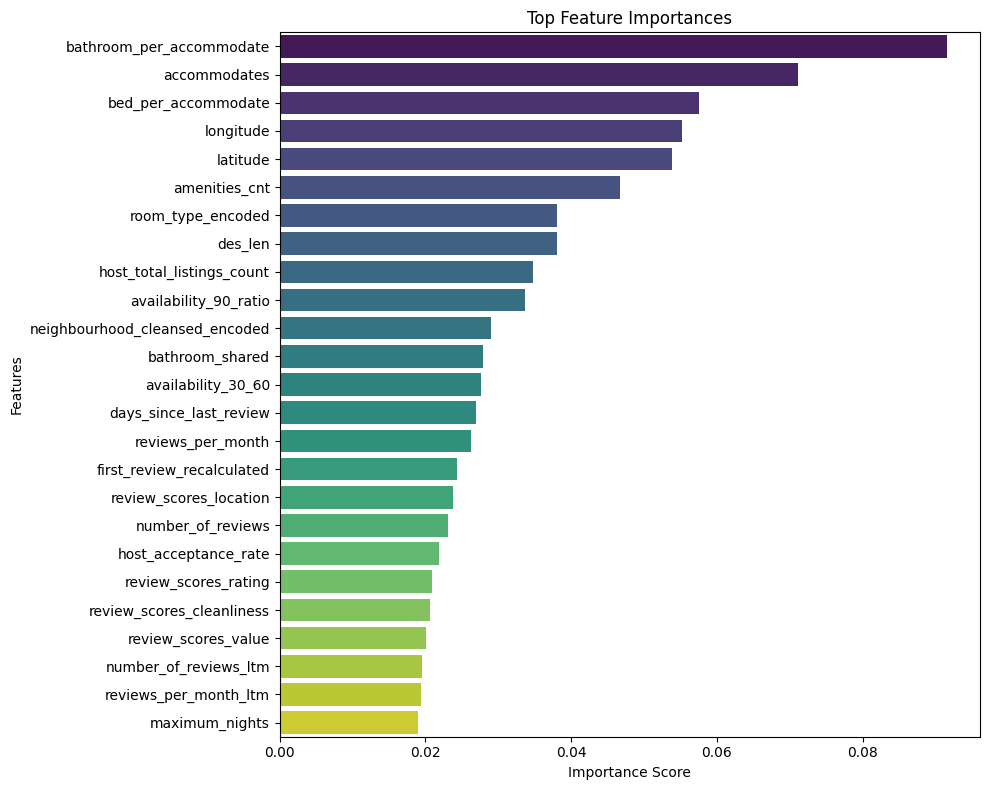

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
X, y = train[selected_features1], train['price']
rf.fit(X, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=selected_features1)
importances = importances.sort_values(ascending=False)

# Select top N features
N = 25
selected_features2 = importances.head(N).index.tolist()
print("Selected Features:", selected_features2)

import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Plot the top N features
sns.barplot(x=importances.head(N), y=importances.head(N).index, palette='viridis')

plt.title('Top Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


## Train Xgboost

In [45]:
# import xgboost as xgb
# from xgboost import XGBClassifier, XGBRegressor
# from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, root_mean_squared_error, make_scorer,mean_squared_error

# X, y = train[selected_features2], train['price']

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# # Hyperparameter grid for XGBoost
# param_grid = {
#     'n_estimators': [500, 1000, 2000],
#     'max_depth': [3, 6, 9, 11],
#     'learning_rate': [0.005, 0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.01, 0.1],
#     'reg_lambda': [1, 1.5, 2],
#     'min_child_weight': [1, 5, 10],
#     'max_delta_step': [0, 1, 5]
# }

# xgb_reg = XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42
# )

# random_search = RandomizedSearchCV(
#     estimator=xgb_reg,
#     param_distributions=param_grid,
#     n_iter=50,                    # Number of parameter settings that are sampled
#     scoring=rmse_scorer,           # Metric to optimize
#     cv=10,                         # 10-fold cross-validation
#     verbose=1,
#     random_state=42,
#     n_jobs=-1                     # Use all available cores
# )

# # Fit the random search model
# random_search.fit(X_train, y_train)

# best_params = random_search.best_params_
# print("Best Hyperparameters:")
# print(random_search.best_params_)
# # Cross-validation with the best parameters
# best_xgb_reg = XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42,
#     early_stopping_rounds=10,
#     **best_params
# )

# # Cross-validate on the training set
# cv_scores = cross_val_score(
#     best_xgb_reg,
#     X_train,
#     y_train,
#     cv=10,
#     scoring=rmse_scorer,
#     n_jobs=-1
# )

# cv_rmse_scores = -cv_scores
# print("Cross-validated RMSE scores:", cv_rmse_scores)
# print("Mean CV RMSE:", cv_rmse_scores.mean())

# # Train the model on the entire training data
# best_xgb_reg.fit(X_train, y_train)

# # Evaluate the model on the test set
# y_pred = best_xgb_reg.predict(X_val)
# test_rmse = root_mean_squared_error(y_val, y_pred)
# print(f"Test RMSE: {test_rmse:.2f}")


In [46]:
def convert_to_classes(y_pred):

    y_pred_round = np.round(y_pred)
    y_pred_clip = np.clip(y_pred_round, 0, 5).astype(int)

    return y_pred_clip
# y_pred_clip = convert_to_classes(y_pred)
# print(f"Test RMSE: {root_mean_squared_error(y_val, y_pred_clip):.2f}")

In [47]:
# X_test = test[selected_features3]
# y_test_pred = best_xgb_reg.predict(X_test)
# y_test_pred = convert_to_classes(y_test_pred)
# submission = pd.DataFrame({
#     'id': test['id'],
#     'price': y_test_pred
#     })
# submission.to_csv('submission_xgb.csv', index=False, header=['id', 'price'])

In [48]:
# from xgboost import plot_importance
# plot_importance(best_xgb_reg)

In [49]:
# test.columns

# Train ensemble

## XGBoost

In [50]:
# # Import necessary libraries
# import xgboost as xgb
# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.metrics import root_mean_squared_error, make_scorer
# import pandas as pd

# # Assuming 'train' is your DataFrame and 'selected_features2' is your feature list
# X, y = train[selected_features2], train['price']

# # Split the data
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Define RMSE scorer (negative because lower is better)
# rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# # Hyperparameter grid for XGBoost
# param_grid = {
#     'n_estimators': [500, 1000, 2000],
#     'max_depth': [3, 6, 9, 11],
#     'learning_rate': [0.005, 0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.01, 0.1],
#     'reg_lambda': [1, 1.5, 2],
#     'min_child_weight': [1, 5, 10],
#     'max_delta_step': [0, 1, 5]
# }

# xgb_reg = XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42
# )

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=xgb_reg,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring=rmse_scorer,
#     cv=10,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Perform hyperparameter tuning with early stopping
# random_search.fit(
#     X_train, y_train,
# )

# # Best hyperparameters
# best_params = random_search.best_params_
# print("Best Hyperparameters:")
# print(best_params)

# # Retrain the model with best hyperparameters and early stopping
# best_xgb_reg = XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42,
#     **best_params
# )

# # Cross-validate on the training set
# cv_scores = cross_val_score(
#     best_xgb_reg,
#     X_train,
#     y_train,
#     cv=10,
#     scoring=rmse_scorer,
#     n_jobs=-1
# )

# cv_rmse_scores = -cv_scores
# print("Cross-validated RMSE scores:", cv_rmse_scores)
# print("Mean CV RMSE:", cv_rmse_scores.mean())

# best_xgb_reg.fit(
#     X_train, y_train,
#     verbose=0
# )

# # Predict on validation set
# y_pred = best_xgb_reg.predict(X_val)

# # Calculate RMSE
# test_rmse = root_mean_squared_error(y_val, y_pred)
# print(f"XGBoost Validation RMSE: {test_rmse:.2f}")

In [51]:
# # Calculate RMSE
# test_rmse = root_mean_squared_error(y_val, y_pred)
# print(f"XGBoost Validation RMSE: {test_rmse:.2f}")

## Light GBM

In [52]:
# import lightgbm as lgb
# from lightgbm import LGBMRegressor

# # Hyperparameter grid for LightGBM
# lgb_param_grid = {
#     'n_estimators': [1000, 2000, 3000],
#     'max_depth': [5, 10, 15, -1],
#     'learning_rate': [0.005, 0.01, 0.05],
#     'num_leaves': [31, 63, 127, 255],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0.5, 1, 1.5],
# }

# lgb_reg = LGBMRegressor(
#     objective='regression',
#     random_state=42,
#     force_col_wise=True
# )

# # Set up RandomizedSearchCV
# lgb_random_search = RandomizedSearchCV(
#     estimator=lgb_reg,
#     param_distributions=lgb_param_grid,
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Perform hyperparameter tuning with early stopping
# lgb_random_search.fit(
#     X_train, y_train
# )

# # Best hyperparameters
# lgb_best_params = lgb_random_search.best_params_
# print("Best LightGBM Hyperparameters:")
# print(lgb_best_params)

# # Retrain the model with best hyperparameters
# best_lgb_reg = LGBMRegressor(
#     objective='regression',
#     random_state=42,
#     **lgb_best_params
# )

# best_lgb_reg.fit(
#     X_train, y_train,
#     verbose=0
# )

# # Predict on validation set
# y_pred_lgb = best_lgb_reg.predict(X_val)

# # Calculate RMSE
# rmse_lgb = root_mean_squared_error(y_val, y_pred_lgb)
# print(f"LightGBM Validation RMSE: {rmse_lgb:.2f}")

In [53]:
# import lightgbm as lgb
# from sklearn.model_selection import RandomizedSearchCV, train_test_split

# # Assuming 'train' is your DataFrame and 'selected_features2' is your feature list
# X, y = train[selected_features2], train['price']

# # Split the data
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Simplified hyperparameter grid
# lgb_param_grid = {
#     'n_estimators': [500],
#     'max_depth': [6, 8],
#     'learning_rate': [0.05, 0.1],
#     'num_leaves': [31, 63],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
#     'reg_alpha': [0.0],
#     'reg_lambda': [0.0],
#     'min_child_weight': [1],
# }

# n_iter_search = 10  # Number of parameter settings that are sampled
# cv_folds = 5        # Number of cross-validation folds

# # Define the model
# lgb_reg = lgb.LGBMRegressor(
#     objective='regression',
#     force_col_wise=True,
#     random_state=42,
#     n_jobs=-1  # Use all available CPU cores
# )

# # Set up RandomizedSearchCV
# lgb_random_search = RandomizedSearchCV(
#     estimator=lgb_reg,
#     param_distributions=lgb_param_grid,
#     n_iter=n_iter_search,
#     scoring='neg_root_mean_squared_error',
#     cv=cv_folds,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Perform hyperparameter tuning with early stopping
# lgb_random_search.fit(
#     X_train, y_train
# )

# # Best hyperparameters
# lgb_best_params = lgb_random_search.best_params_
# print("Best LightGBM Hyperparameters:")
# print(lgb_best_params)

# # Retrain the model with best hyperparameters
# best_lgb_reg = lgb.LGBMRegressor(
#     objective='regression',
#     random_state=42,
#     n_jobs=-1,
#     **lgb_best_params
# )

# best_lgb_reg.fit(
#     X_train, y_train
# )

# # Predict on validation set
# y_pred_lgb = best_lgb_reg.predict(X_val)

# # Calculate RMSE
# rmse_lgb = root_mean_squared_error(y_val, y_pred_lgb)
# print(f"LightGBM Validation RMSE: {rmse_lgb:.2f}")

## RF

In [54]:
# from sklearn.ensemble import RandomForestRegressor

# # Hyperparameter grid for Random Forest
# rf_param_grid = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [5, 10, 15, 20, None],
#     'min_samples_split': [2, 5, 10, 20],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 0.3, 0.5],
#     'bootstrap': [True, False]
# }

# rf_reg = RandomForestRegressor(random_state=42)

# # Set up RandomizedSearchCV
# rf_random_search = RandomizedSearchCV(
#     estimator=rf_reg,
#     param_distributions=rf_param_grid,
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Perform hyperparameter tuning
# rf_random_search.fit(X_train, y_train)

# # Best hyperparameters
# rf_best_params = rf_random_search.best_params_
# print("Best Random Forest Hyperparameters:")
# print(rf_best_params)

# # Retrain the model with best hyperparameters
# best_rf_reg = RandomForestRegressor(
#     random_state=42,
#     **rf_best_params
# )

# best_rf_reg.fit(X_train, y_train)

# # Predict on validation set
# y_pred_rf = best_rf_reg.predict(X_val)

# # Calculate RMSE
# rmse_rf = root_mean_squared_error(y_val, y_pred_rf)
# print(f"Random Forest Validation RMSE: {rmse_rf:.2f}")

## Combine

In [55]:
# y_pred_xgb = best_xgb_reg.predict(X_val)
# # Ensemble predictions by averaging
# y_pred_ensemble = (y_pred_xgb + y_pred_lgb + y_pred_rf) / 3

# # Calculate RMSE for ensemble
# rmse_ensemble = root_mean_squared_error(y_val, y_pred_ensemble)

# print(f"Ensemble Validation RMSE: {rmse_ensemble:.2f}")
# print(f"XGBoost Validation RMSE: {test_rmse:.2f}")
# print(f"LightGBM Validation RMSE: {rmse_lgb:.2f}")
# print(f"Random Forest Validation RMSE: {rmse_rf:.2f}")
# print(f"Ensemble Validation RMSE: {rmse_ensemble:.2f}")

# # Calculate weights based on validation RMSE
# total_rmse = 1 / test_rmse + 1 / rmse_lgb + 1 / rmse_rf
# weights = [
#     (1 / test_rmse) / total_rmse,
#     (1 / rmse_lgb) / total_rmse,
#     (1 / rmse_rf) / total_rmse
# ]

# # Weighted ensemble predictions
# y_pred_weighted = (
#     y_pred_xgb * weights[0] +
#     y_pred_lgb * weights[1] +
#     y_pred_rf * weights[2]
# )

# rmse_weighted = root_mean_squared_error(y_val, y_pred_weighted)
# print(f"Weighted Ensemble Validation RMSE: {rmse_weighted:.2f}")

In [56]:
# X_test = test[selected_features2]
# y_test_xgb = best_xgb_reg.predict(X_test)
# y_test_lgm = best_lgb_reg.predict(X_test)
# y_test_rf = best_rf_reg.predict(X_test)

# y_pred_weighted = (
#     y_test_xgb * weights[0] +
#     y_test_lgm * weights[1] +
#     y_test_rf * weights[2]
# )

# def convert_to_classes(y_pred):

#     y_pred_round = np.round(y_pred)
#     y_pred_clip = np.clip(y_pred_round, 0, 5).astype(int)

#     return y_pred_clip
# # Calculate RMSE
# y_pred = convert_to_classes(y_pred_weighted)

# submission = pd.DataFrame({
#     'id': test['id'],
#     'price': y_pred
#     })
# submission.to_csv('submission.csv', index=False, header=['id', 'price'])

In [57]:
# y_pred_ensemble_test = (y_test_xgb + y_test_lgm + y_test_rf) / 3

# submission = pd.DataFrame({
#     'id': test['id'],
#     'price': y_pred_ensemble_test
#     })
# submission.to_csv('submission.csv', index=False, header=['id', 'price'])

In [58]:
# y_test_rf[3]

# Train Stack Regressor

In [59]:
import pandas as pd
import numpy as np

# Models
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# Hyperparameter tuning and cross-validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, make_scorer
import tensorflow as tf

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

X_train_full = train[selected_features2]
y_train_full = train['price']

# Split the data into training and validation sets

# Define RMSE scorer (negative because lower is better)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [60]:
# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [1500, 2000, 2500],
    'max_depth': [7, 9, 11],
    'learning_rate': [0.01, 0.005],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'gamma': [0.2],
    'reg_alpha': [0.1],
    'reg_lambda': [1.5, 2.0],
    'min_child_weight': [7],
}

xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# RandomizedSearchCV for XGBoost
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring=rmse_scorer,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform hyperparameter tuning
# Record time
import time
time_cost = {}
start_time = time.time()
# xgb_random_search.fit(X_train_full, y_train_full)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for tuning: {elapsed_time:.2f} seconds")
time_cost['xgb'] = elapsed_time
# Best hyperparameters
xgb_best_params = {'subsample': 0.8,
                   'reg_lambda': 1.5,
                   'reg_alpha': 0.1,
                   'n_estimators': 2000,
                   'min_child_weight': 7,
                   'max_depth': 9,
                   'learning_rate': 0.01,
                   'gamma': 0.2,
                   'colsample_bytree': 0.9}
print("Best XGBoost Hyperparameters:")
print(xgb_best_params)
best_xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **xgb_best_params
)



Time taken for tuning: 0.00 seconds
Best XGBoost Hyperparameters:
{'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}


In [61]:
selected_features2

['bathroom_per_accommodate',
 'accommodates',
 'bed_per_accommodate',
 'longitude',
 'latitude',
 'amenities_cnt',
 'room_type_encoded',
 'des_len',
 'host_total_listings_count',
 'availability_90_ratio',
 'neighbourhood_cleansed_encoded',
 'bathroom_shared',
 'availability_30_60',
 'days_since_last_review',
 'reviews_per_month',
 'first_review_recalculated',
 'review_scores_location',
 'number_of_reviews',
 'host_acceptance_rate',
 'review_scores_rating',
 'review_scores_cleanliness',
 'review_scores_value',
 'number_of_reviews_ltm',
 'reviews_per_month_ltm',
 'maximum_nights']

In [62]:
time_cost = {}
time_cost['xgb'] = 3209.5

n_estimators: 500, Validation RMSE: 0.8841
n_estimators: 1000, Validation RMSE: 0.8749
n_estimators: 1500, Validation RMSE: 0.8740
n_estimators: 2000, Validation RMSE: 0.8739
n_estimators: 2500, Validation RMSE: 0.8739


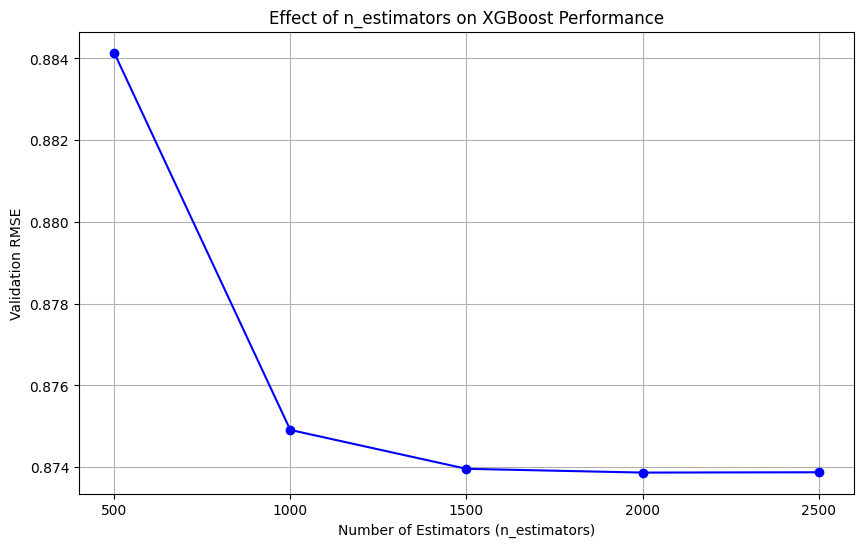

In [63]:
# Assume 'train' is your DataFrame and 'selected_features2' is your feature list
X = train[selected_features2]
y = train['price']

# Split the data into training and validation subsets
X_train_subset, X_val_subset, y_train_subset, y_val_subset = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Hyperparameters to test
n_estimators_list = [500, 1000, 1500, 2000, 2500]

# Store results
rmse_list = []

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer
# Loop over different n_estimators
for n_estimators in n_estimators_list:
    xgb_reg = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=9,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.2,
        reg_alpha=0.1,
        reg_lambda=1.5,
        min_child_weight=7,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    # Fit the model
    xgb_reg.fit(X_train_subset, y_train_subset)

    # Predict on validation set
    y_pred = xgb_reg.predict(X_val_subset)

    # Calculate RMSE
    rmse = root_mean_squared_error(y_val_subset, y_pred)
    rmse_list.append(rmse)
    print(f"n_estimators: {n_estimators}, Validation RMSE: {rmse:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, rmse_list, marker='o', linestyle='-', color='b')
plt.title('Effect of n_estimators on XGBoost Performance')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Validation RMSE')
plt.xticks(n_estimators_list)
plt.grid(True)
plt.show()


=== Test-Set Performance ===
                      RMSE       MAE        R²  MAPE (%)
Model                                                   
Mean Predictor    1.622147  1.383189 -0.002070       inf
Ridge Regression  1.233159  0.986043  0.420897       inf
XGBoost (ours)    0.910914  0.647150  0.684011       inf

XGBoost 5-fold CV RMSE: 0.8616 ± 0.0204


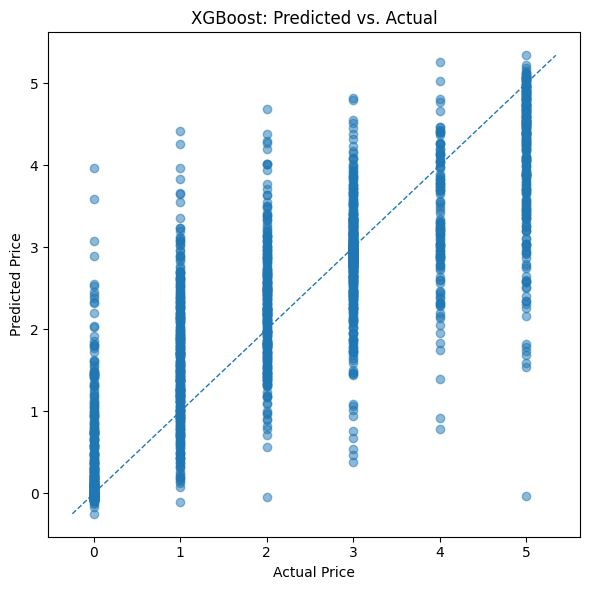

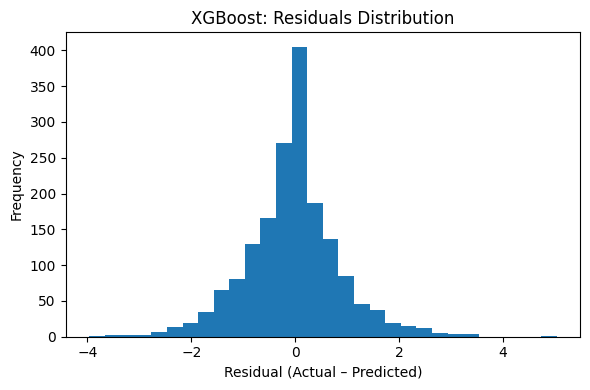

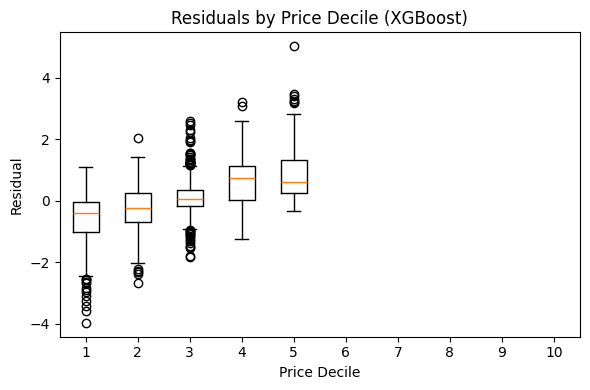


Top 5 Best-Predicted Listings:
      bathroom_per_accommodate  accommodates  bed_per_accommodate  longitude  \
1454                  2.009530     -0.772899             0.042952   1.759642   
371                  -0.421587     -0.138553             0.916559  -1.019182   
828                   6.871763     -1.090072             1.790166  -3.438991   
1188                  0.388785     -0.138553             0.042952   0.752949   
929                  -1.231960     -0.772899            -1.704262   0.251360   

      latitude  amenities_cnt  room_type_encoded   des_len  \
1454 -1.604135       0.057757                  0  0.494399   
371   1.671739       1.179030                  0  0.937608   
828   1.515839      -0.074157                  2  1.259941   
1188 -0.236839      -0.535858                  0 -0.512893   
929   0.865762      -0.140114                  2  0.695858   

      host_total_listings_count  availability_90_ratio  ...  \
1454                  -0.343033               0.645

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from xgboost import XGBRegressor

# --- 1. Data Preparation & Splitting (60/20/20) ---
X = train[selected_features2]
y = train['price']

# 20% held out for final test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_test = test[selected_features2]
y_test = test['price']

# --- 2. Baseline: Mean Predictor ---
mean_baseline = DummyRegressor(strategy='mean')
mean_baseline.fit(X_train, y_train)

# --- 3. Ridge Regression with 5-fold CV ---
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10]}
grid_ridge = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_

# --- 4. XGBoost (fixed hyperparameters) ---
xgb = XGBRegressor(
    n_estimators=1500,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=1.5,
    min_child_weight=7,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb.fit(X_train, y_train)

# --- 5. Final Evaluation on Test Set ---
models = {
    'Mean Predictor': mean_baseline,
    'Ridge Regression': best_ridge,
    'XGBoost (ours)': xgb
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    })

metrics_df = pd.DataFrame(results).set_index('Model')
print("\n=== Test-Set Performance ===")
print(metrics_df)

# --- 6. 5-Fold CV RMSE on Training+Validation Set ---
cv_scores = cross_val_score(
    xgb,
    X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
cv_rmse = -cv_scores
print(f"\nXGBoost 5-fold CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

# --- 7. Visualizations ---

# 7a) Predicted vs. Actual (XGBoost)
y_xgb_test = xgb.predict(X_test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_xgb_test, alpha=0.5)
lims = [min(y_test.min(), y_xgb_test.min()), max(y_test.max(), y_xgb_test.max())]
plt.plot(lims, lims, '--', linewidth=1)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost: Predicted vs. Actual')
plt.tight_layout()
plt.show()

# 7b) Residuals Histogram (XGBoost)
residuals = y_test - y_xgb_test
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel('Residual (Actual – Predicted)')
plt.ylabel('Frequency')
plt.title('XGBoost: Residuals Distribution')
plt.tight_layout()
plt.show()

# 7c) Residuals by Price Decile
deciles = pd.qcut(y_test, 10, labels=False, duplicates='drop')
plt.figure(figsize=(6,4))
plt.boxplot(
    [residuals[deciles == i] for i in range(10)],
    labels=[f'{i+1}' for i in range(10)]
)
plt.xlabel('Price Decile')
plt.ylabel('Residual')
plt.title('Residuals by Price Decile (XGBoost)')
plt.tight_layout()
plt.show()

# --- 8. Examples of Success & Failure (XGBoost) ---
test_df = X_test.copy()
test_df['actual_price']    = y_test
test_df['predicted_price'] = y_xgb_test
test_df['abs_error']       = (test_df['actual_price'] - test_df['predicted_price']).abs()

print("\nTop 5 Best-Predicted Listings:")
print(test_df.nsmallest(5, 'abs_error')[
    selected_features2 + ['actual_price','predicted_price','abs_error']
])

print("\nTop 5 Worst-Predicted Listings:")
print(test_df.nlargest(5, 'abs_error')[
    selected_features2 + ['actual_price','predicted_price','abs_error']
])


In [65]:
X_test = test[selected_features2]
y_test = test['price']


xgb_reg = XGBRegressor(
        n_estimators=2500,
        max_depth=9,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.2,
        reg_alpha=0.1,
        reg_lambda=1.5,
        min_child_weight=7,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

# Fit the model
xgb_reg.fit(X, y)

# Predict on validation set
y_pred_test = xgb_reg.predict(X_test)


rmse_test = root_mean_squared_error(y_test, y_pred_test)


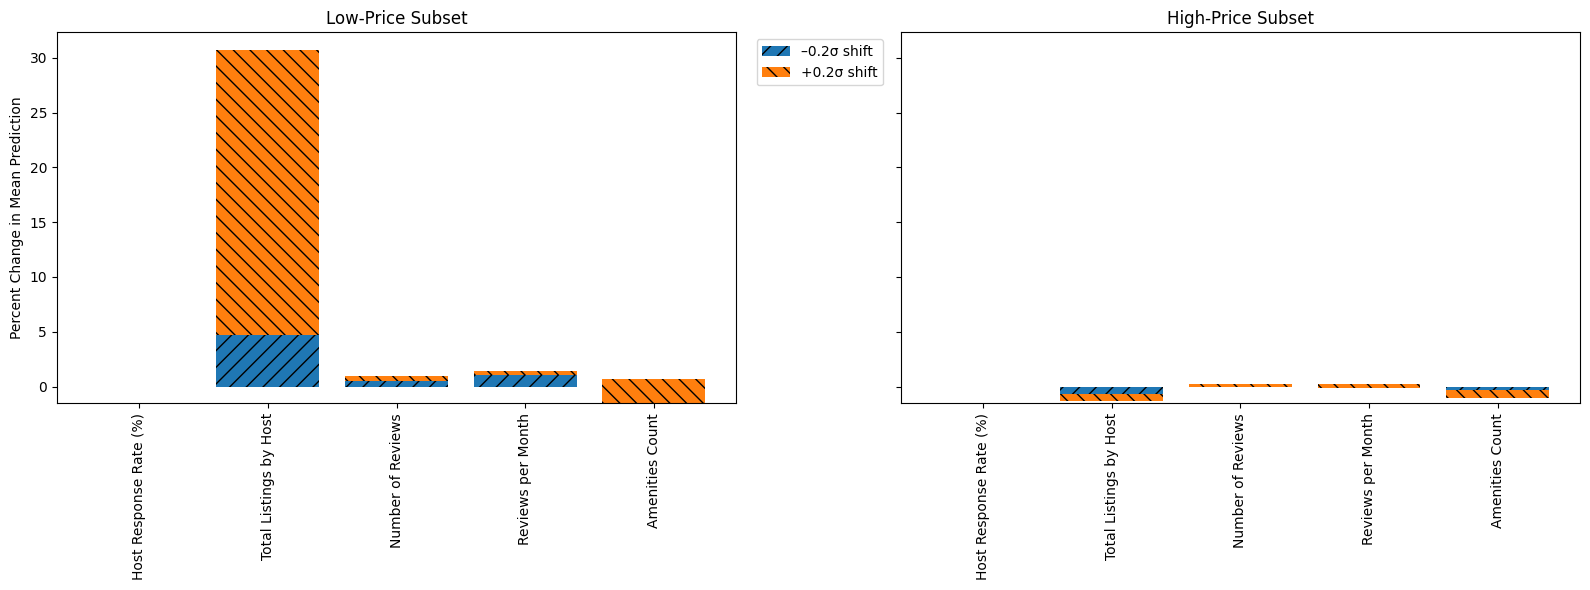

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# 0. A dict to map your raw column names to nice labels:
label_map = {
    'host_response_rate':        'Host Response Rate (%)',
    'host_total_listings_count': 'Total Listings by Host',
    'number_of_reviews':         'Number of Reviews',
    'reviews_per_month':         'Reviews per Month',
    'amenities_cnt':             'Amenities Count'
}

def compute_price_changes(df, features, model):
    results = []
    for col in numerical_cols:
        μ = df[col].mean()
        σ = df[col].std()

        # shift ±0.2·σ
        df_l = df.copy()
        df_r = df.copy()
        df_l[col] -= 0.2 * abs(σ)
        df_r[col] += 0.2 * abs(σ)

        y0 = model.predict(df[features]).mean()
        yL = model.predict(df_l[features]).mean()
        yR = model.predict(df_r[features]).mean()

        results.append({
            'column':      col,
            'left_shift':  (yL - y0) / y0 * 100,
            'right_shift': (yR - y0) / y0 * 100
        })
    return pd.DataFrame(results)

# 1. Define your numeric cols & features
numerical_cols = [
    'host_response_rate',
    'host_total_listings_count',
    'number_of_reviews',
    'reviews_per_month',
    'amenities_cnt'
]
features = selected_features2  # whatever feature list you passed to xgb_reg

# 2. Split test set at the median price
med = test['price'].median()
low_df  = test[test['price'] <  med]
high_df = test[test['price'] >= med]

# 3. Compute price‐change tables
low_changes  = compute_price_changes(low_df,  features, xgb_reg)
high_changes = compute_price_changes(high_df, features, xgb_reg)

# 4. Plot side by side, using mapped labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# positions for the bars
x_low  = np.arange(len(low_changes))
x_high = np.arange(len(high_changes))

# Low‐priced houses
ax1.bar(x_low, low_changes['left_shift'],
        label='–0.2σ shift', hatch='//')
ax1.bar(x_low, low_changes['right_shift'],
        bottom=low_changes['left_shift'],
        label='+0.2σ shift', hatch='\\\\')
ax1.set_title('Low-Price Subset')
ax1.set_xticks(x_low)
ax1.set_xticklabels(
    [label_map.get(col, col) for col in low_changes['column']],
    rotation=90
)
ax1.set_ylabel('Percent Change in Mean Prediction')

# High‐priced houses
ax2.bar(x_high, high_changes['left_shift'],
        label='–0.2σ shift', hatch='//')
ax2.bar(x_high, high_changes['right_shift'],
        bottom=high_changes['left_shift'],
        label='+0.2σ shift', hatch='\\\\')
ax2.set_title('High-Price Subset')
ax2.set_xticks(x_high)
ax2.set_xticklabels(
    [label_map.get(col, col) for col in high_changes['column']],
    rotation=90
)

# Common legend
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()


In [67]:
numerical_cols

['host_response_rate',
 'host_total_listings_count',
 'number_of_reviews',
 'reviews_per_month',
 'amenities_cnt']

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils import resample

# ─── 0. LOAD YOUR DATA ──────────────────────────────────────────────────────────
features   = selected_features2   # your feature list
target_col = 'price'             # already binned: e.g. 0,1,2,...,N-1

# discover all classes (bins), sorted
classes = sorted(train[target_col].unique())
y_test  = test[target_col].values

# ─── 0.1 SHOW TEST-SET DISTRIBUTION ────────────────────────────────────────────
test_counts = test[target_col].value_counts().sort_index()
test_pct    = (test_counts / test_counts.sum() * 100).round(2)
test_dist   = pd.DataFrame({'count': test_counts, 'pct (%)': test_pct})

print(">>> Test-set distribution:")
print(test_dist, "\n")

# ─── 1. REBALANCING HELPERS ────────────────────────────────────────────────────
def rebalance_uniform(df):
    """Oversample each class to the size of the largest class."""
    max_n = df[target_col].value_counts().max()
    parts = []
    for cls in classes:
        cls_df = df[df[target_col] == cls]
        parts.append(resample(
            cls_df,
            replace=True,
            n_samples=max_n,
            random_state=42
        ))
    return pd.concat(parts)

def rebalance_skew_bell(df, skew_side='right'):
    """
    Oversample bins according to a bell-curve peaking at one extreme.
    skew_side='right' peaks at the highest bin, 'left' at the lowest.
    """
    N = len(df)
    idx = np.arange(len(classes))
    mu = idx[-1] if skew_side == 'right' else idx[0]
    sigma = len(classes) / 3.0
    pdf = np.exp(-0.5 * ((idx - mu) / sigma) ** 2)
    weights = pdf / pdf.sum()

    counts = np.round(weights * N).astype(int)
    diff = N - counts.sum()
    peak_idx = int(mu)
    counts[peak_idx] += diff

    parts = []
    for cls, cnt in zip(classes, counts):
        cls_df = df[df[target_col] == cls]
        parts.append(resample(
            cls_df,
            replace=True,
            n_samples=cnt,
            random_state=42
        ))
    return pd.concat(parts)

def rebalance_middle_bell(df):
    """
    Oversample bins according to a bell-curve peaking at the center bin(s).
    """
    N = len(df)
    idx = np.arange(len(classes))
    mu = idx.mean()  # center of classes
    sigma = len(classes) / 5.0
    pdf = np.exp(-0.5 * ((idx - mu) / sigma) ** 2)
    weights = pdf / pdf.sum()

    counts = np.round(weights * N).astype(int)
    diff = N - counts.sum()
    peak_idx = int(round(mu))
    counts[peak_idx] += diff

    parts = []
    for cls, cnt in zip(classes, counts):
        cls_df = df[df[target_col] == cls]
        parts.append(resample(
            cls_df,
            replace=True,
            n_samples=cnt,
            random_state=42
        ))
    return pd.concat(parts)


# ─── 2. SET UP SCENARIOS ────────────────────────────────────────────────────────
scenarios = {
    'baseline':    train,
    'uniform':     rebalance_uniform(train),
    'right_skew':  rebalance_skew_bell(train, 'right'),
    'left_skew':   rebalance_skew_bell(train, 'left'),
    'middle_peak': rebalance_middle_bell(train),
}

# ─── 3. TRAIN & EVALUATE ─────────────────────────────────────────────────────────
for name, df in scenarios.items():
    # 3a) show training-set distribution for this scenario
    tr_counts = df[target_col].value_counts().sort_index()
    tr_pct    = (tr_counts / tr_counts.sum() * 100).round(2)
    tr_dist   = pd.DataFrame({'count': tr_counts, 'pct (%)': tr_pct})
    print(f"\n>>> [{name}] train-set distribution:")
    print(tr_dist, "\n")

    # 3b) train classifier
    X_tr, y_tr = df[features], df[target_col]
    clf = XGBClassifier(
        n_estimators=2500,
        max_depth=9,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.2,
        reg_alpha=0.1,
        reg_lambda=1.5,
        min_child_weight=7,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    clf.fit(X_tr, y_tr)

    # 3c) predict & evaluate on the same test set
    y_pred = clf.predict(test[features])
    acc    = accuracy_score(y_test, y_pred)
    print(f"[{name}] Accuracy: {acc:.3f}\n")

    cm = confusion_matrix(y_test, y_pred, labels=classes)
    print(f"[{name}] Confusion Matrix (true vs. pred):")
    print(cm, "\n")

    names = [f"Bin {cls}" for cls in classes]
    print(f"[{name}] Classification Report:")
    print(classification_report(
        y_test,
        y_pred,
        labels=classes,
        target_names=names
    ))


>>> Test-set distribution:
       count  pct (%)
price                
0        286    16.34
1        324    18.51
2        287    16.40
3        464    26.51
4        125     7.14
5        264    15.09 


>>> [baseline] train-set distribution:
       count  pct (%)
price                
0       1175    16.79
1       1140    16.29
2       1166    16.66
3       1711    24.45
4        617     8.82
5       1189    16.99 

[baseline] Accuracy: 0.581

[baseline] Confusion Matrix (true vs. pred):
[[228  39  16   2   0   1]
 [ 56 144  88  15   8  13]
 [ 12  73 137  35  11  19]
 [  8  23  73 295  27  38]
 [  4   7  24  26  25  39]
 [  2   5  18  27  24 188]] 

[baseline] Classification Report:
              precision    recall  f1-score   support

       Bin 0       0.74      0.80      0.77       286
       Bin 1       0.49      0.44      0.47       324
       Bin 2       0.38      0.48      0.43       287
       Bin 3       0.74      0.64      0.68       464
       Bin 4       0.26      0.20 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Assuming X_test, y_test, and xgb_reg are already defined

noise_levels = [0, 0.1, 0.5, 1, 2]
metrics = {
    'rmse': [],
    'mae': [],
    'r2': []
}

for noise_level in noise_levels:
    # Add Gaussian noise to numerical features in X_test
    X_test_noisy = X_test.copy()
    numerical_cols = X_test.select_dtypes(include=np.number).columns
    noise = np.random.normal(
        loc=0,
        scale=noise_level,
        size=X_test[numerical_cols].shape
    )
    X_test_noisy[numerical_cols] += noise

    # Predict on the noisy test set
    y_pred = xgb_reg.predict(X_test_noisy)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['r2'].append(r2)

# --- Plotting all metrics ---
fig, ax_err = plt.subplots(figsize=(10, 6))

# Plot RMSE and MAE on the left y-axis
ax_err.plot(noise_levels, metrics['rmse'], 'o-', label='RMSE')
ax_err.plot(noise_levels, metrics['mae'],  's--', label='MAE')
ax_err.set_xlabel('Noise Level (Std Dev)')
ax_err.set_ylabel('Error', color='tab:blue')
ax_err.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for R²
ax_r2 = ax_err.twinx()
ax_r2.plot(noise_levels, metrics['r2'], 'd-.', label='R² Score')
ax_r2.set_ylabel('R² Score', color='tab:red')
ax_r2.tick_params(axis='y', labelcolor='tab:red')

# Combine legends from both axes
err_handles, err_labels = ax_err.get_legend_handles_labels()
r2_handles,  r2_labels  = ax_r2.get_legend_handles_labels()
ax_err.legend(
    err_handles + r2_handles,
    err_labels  + r2_labels,
    loc='best'
)

plt.title('XGBoost Regression Performance under Increasing Gaussian Noise')
plt.xticks(noise_levels)
ax_err.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    median_absolute_error, mean_absolute_percentage_error,
    max_error, r2_score, explained_variance_score
)

# --- Assume X_test, y_test, and xgb_reg are already defined in your notebook ---

noise_levels = [0, 0.1, 0.3, 0.5, 0.8, 1]
metrics = {
    'rmse': [],
    'mae': [],
    'medae': [],
    'mape': [],
    'max_error': [],
    'r2': [],
    'explained_var': []
}

# Compute all metrics across noise levels
for nl in noise_levels:
    Xn = X_test.copy()
    num_cols = Xn.select_dtypes(include=np.number).columns
    Xn[num_cols] += np.random.normal(0, nl, size=Xn[num_cols].shape)
    y_pred = xgb_reg.predict(Xn)

    metrics['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    metrics['mae'].append(mean_absolute_error(y_test, y_pred))
    metrics['medae'].append(median_absolute_error(y_test, y_pred))
    # metrics['mape'].append(mean_absolute_percentage_error(y_test, y_pred))
    metrics['max_error'].append(max_error(y_test, y_pred))
    metrics['r2'].append(r2_score(y_test, y_pred))
    metrics['explained_var'].append(explained_variance_score(y_test, y_pred))

# Build a DataFrame for baseline (noise=0)
baseline_df = pd.DataFrame({
    'Metric': ['RMSE',
               'MAE',
               'MedAE',
              #  'MAPE',
               'Max Error', 'R² Score', 'Explained Var'],
    'Baseline (no noise)': [
        metrics['rmse'][0],
        metrics['mae'][0],
        metrics['medae'][0],
        # metrics['mape'][0],
        metrics['max_error'][0],
        metrics['r2'][0],
        metrics['explained_var'][0],
    ]
})
baseline_df.set_index('Metric', inplace=True)

# Pretty display with styling
display(
    baseline_df.style
               .format("{:.3f}")
               .set_caption("Baseline Performance (Noise = 0)")
               .background_gradient(cmap='Blues')
)

# Optionally, plot metrics vs. noise as before
fig, ax_err = plt.subplots(figsize=(12, 6))
ax_err.plot(noise_levels, metrics['rmse'],      'o-',  label='RMSE')
ax_err.plot(noise_levels, metrics['mae'],       's--', label='MAE')
ax_err.plot(noise_levels, metrics['medae'],     '^-',  label='MedAE')
# ax_err.plot(noise_levels, metrics['mape'],      'v:',  label='MAPE')
ax_err.plot(noise_levels, metrics['max_error'], 'd-.', label='Max Error')
ax_err.set_xlabel('Noise Level (Std Dev)')
ax_err.set_ylabel('Error', color='tab:blue')
ax_err.tick_params(axis='y', labelcolor='tab:blue')

ax_score = ax_err.twinx()
ax_score.plot(noise_levels, metrics['r2'],            'p-',  label='R² Score')
ax_score.plot(noise_levels, metrics['explained_var'], 'h--', label='Explained Var')
ax_score.set_ylabel('Score', color='tab:red')
ax_score.tick_params(axis='y', labelcolor='tab:red')

h1, l1 = ax_err.get_legend_handles_labels()
h2, l2 = ax_score.get_legend_handles_labels()
ax_err.legend(h1 + h2, l1 + l2, loc='upper right')

plt.title('XGBoost Regression: Multiple Metrics vs. Gaussian Noise')
plt.xticks(noise_levels)
ax_err.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# --- assume X_test, y_test, xgb_reg are already defined ---

# Identify numeric columns
numerical_cols = X_test.select_dtypes(include=np.number).columns

# Baseline performance (no noise)
y_pred_base = xgb_reg.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
baseline_mae = mean_absolute_error(y_test, y_pred_base)
baseline_r2 = r2_score(y_test, y_pred_base)

# Containers for noisy performance
rmse_list, mae_list, r2_list = [], [], []

# Apply noise = 0.1 * std(col) to each feature individually
for col in numerical_cols:
    Xn = X_test.copy()
    std = X_test[col].std()
    Xn[col] += np.random.normal(0, 0.1 * std, size=Xn[col].shape)
    y_pred = xgb_reg.predict(Xn)
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_list.append(mean_absolute_error(y_test, y_pred))
    r2_list.append(r2_score(y_test, y_pred))

# Build results DataFrame
results_df = pd.DataFrame({
    'RMSE':     rmse_list,
    'MAE':      mae_list,
    'R² Score': r2_list
}, index=numerical_cols)

# Display styled table
display(
    results_df.style
              .format("{:.3f}")
              .set_caption("Performance with 0.1×StdDev Noise per Feature")
              .background_gradient(cmap='Oranges')
)




In [ ]:
# Combined plot: bars for errors, line for R², plus baseline lines
fig, ax_err = plt.subplots(figsize=(12, 6))
idx = np.arange(len(numerical_cols))
width = 0.35

# Bars for RMSE and MAE (noisy)
ax_err.bar(idx - width/2, results_df['RMSE'], width, label='RMSE (noisy)')
ax_err.bar(idx + width/2, results_df['MAE'],  width, label='MAE (noisy)')

# Baseline error lines
ax_err.hlines(baseline_rmse, xmin=-0.5, xmax=len(numerical_cols)-0.5,
              linestyles='--', label='RMSE (baseline)')
ax_err.hlines(baseline_mae, xmin=-0.5, xmax=len(numerical_cols)-0.5,
              linestyles=':',  label='MAE (baseline)', color = 'orange')

ax_err.set_xlabel('Feature')
ax_err.set_ylabel('Error')
ax_err.set_xticks(idx)
ax_err.set_xticklabels(numerical_cols, rotation=45, ha='right')

# Secondary axis for R²
ax_r2 = ax_err.twinx()
ax_r2.plot(idx, results_df['R² Score'], marker='o', label='R² (noisy)', color = 'red')
ax_r2.hlines(baseline_r2, xmin=-0.5, xmax=len(numerical_cols)-0.5,
             linestyles='-.', label='R² (baseline)', color = 'red')
ax_r2.set_ylabel('R² Score')

# Combine legends from both axes
handles_err, labels_err = ax_err.get_legend_handles_labels()
handles_r2,  labels_r2  = ax_r2.get_legend_handles_labels()
ax_err.legend(handles_err + handles_r2, labels_err + labels_r2, loc='upper left')

plt.title('XGBoost: Noise Impact on Individual Features vs. Baseline')
plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter grid for LightGBM
# lgb_param_grid = {S
#     'n_estimators': [500, 1000, 2000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [31, 63, 127],
#     'max_depth': [-1, 5, 10],
#     'min_child_samples': [20, 50, 100],
#     'subsample': [0.7, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.9, 1.0],
#     'reg_alpha': [0.0, 0.1, 0.5],
#     'reg_lambda': [0.0, 0.1, 0.5],
#     'min_split_gain': [0.0, 0.1],
# }

# lgb_reg = LGBMRegressor(
#     objective='regression',
#     random_state=42,
#     force_col_wise=True
# )

# # RandomizedSearchCV for LightGBM
# lgb_random_search = RandomizedSearchCV(
#     estimator=lgb_reg,
#     param_distributions=lgb_param_grid,
#     n_iter=20,
#     scoring=rmse_scorer,
#     cv=cv,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Perform hyperparameter tuning
# start_time = time.time()
# lgb_random_search.fit(X_train_full, y_train_full)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Time taken for tuning: {elapsed_time:.2f} seconds")
# time_cost['lgb'] = elapsed_time

# # Best hyperparameters
# lgb_best_params = lgb_random_search.best_params_
# print("Best LightGBM Hyperparameters:")
# print(lgb_best_params)

# best_lgb_reg = LGBMRegressor(
#     objective='regression',
#     random_state=42,
#     **lgb_best_params
# )

In [ ]:
import pandas as pd
import numpy as np

# Models
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# Hyperparameter tuning and cross-validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, make_scorer
import tensorflow as tf

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
import time
X_train_full = train[selected_features2]
y_train_full = train['price']

In [76]:
# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 20, 25],
    'max_features': ['sqrt', 'log2', 0.8],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}

rf_reg = RandomForestRegressor(random_state=42)

# RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=rf_param_grid,
    n_iter=20,
    scoring=rmse_scorer,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform hyperparameter tuning
start_time = time.time()
rf_random_search.fit(X_train_full, y_train_full)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for tuning: {elapsed_time:.2f} seconds")
time_cost['rf'] = elapsed_time

# Best hyperparameters
rf_best_params = rf_random_search.best_params_
print("Best Random Forest Hyperparameters:")
print(rf_best_params)
best_rf_reg = RandomForestRegressor(
    random_state=42,
    **rf_best_params
)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Time taken for tuning: 2570.53 seconds
Best Random Forest Hyperparameters:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 20}


In [77]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

cat_param_grid = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 1, 3],
    'border_count': [32, 64, 128],
}

cat_reg = CatBoostRegressor(random_state=42)

# RandomizedSearchCV for Random Forest
cat_random_search = RandomizedSearchCV(
    estimator=cat_reg,
    param_distributions=cat_param_grid,
    n_iter=20,
    scoring=rmse_scorer,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform hyperparameter tuning
start_time = time.time()
cat_random_search.fit(X_train_full, y_train_full)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for tuning: {elapsed_time:.2f} seconds")
time_cost['cat'] = elapsed_time

# Best hyperparameters
cat_best_params = cat_random_search.best_params_
print("Best CatBoost Hyperparameters:")
print(cat_best_params)
best_cat_reg = CatBoostRegressor(
    random_state=42,
    **cat_best_params
)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
etr_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt'],
}

etr_reg = ExtraTreesRegressor(random_state=42)

# RandomizedSearchCV for Random Forest
etr_random_search = RandomizedSearchCV(
    estimator=etr_reg,
    param_distributions=etr_param_grid,
    n_iter=20,
    scoring=rmse_scorer,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform hyperparameter tuning
start_time = time.time()
etr_random_search.fit(X_train_full, y_train_full)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for tuning: {elapsed_time:.2f} seconds")
time_cost['etr'] = elapsed_time

# Best hyperparameters
etr_best_params = etr_random_search.best_params_
print("Best CatBoost Hyperparameters:")
print(etr_best_params)
best_etr_reg = ExtraTreesRegressor(
    random_state=42,
    **etr_best_params
)
# Initialize the Extra Trees Regressor with the predefined parameters
best_etr_reg = ExtraTreesRegressor(**etr_best_params)

In [ ]:
# etr_param_grid = {
#     'n_estimators': 800,
#     'max_depth': 20,
#     'min_samples_split': 2,
#     'min_samples_leaf': 2,
#     'max_features': 0.8,
#     'max_leaf_nodes': None,
#     'min_impurity_decrease': 0.05,
#     'bootstrap': False,
#     'criterion': 'squared_error',
#     'random_state': 42
# }
# best_etr_reg = ExtraTreesRegressor(**etr_param_grid)

In [ ]:
xgb_best_params = {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}
best_xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **xgb_best_params
)

best_xgb_reg.fit(X_train_full, y_train_full)

# Train each with full train and store test rmse


In [ ]:
# best_lgb_reg = LGBMRegressor(
#     objective='regression',
#     random_state=42,
#     **lgb_best_params
# )

# # # Cross-validation scores
# # lgb_cv_scores = cross_val_score(
# #     best_lgb_reg,
# #     X_train_full,
# #     y_train_full,
# #     cv=cv,
# #     scoring=rmse_scorer,
# #     n_jobs=-1
# # )

# # lgb_cv_rmse_scores = -lgb_cv_scores
# # print("LightGBM Cross-validated RMSE scores:", lgb_cv_rmse_scores)
# # print("LightGBM Mean CV RMSE:", lgb_cv_rmse_scores.mean())

# # Fit the model on the entire training data
# best_lgb_reg.fit(X_train_full, y_train_full)

In [ ]:
best_rf_reg = RandomForestRegressor(
    random_state=42,
    **rf_best_params
)

# # Cross-validation scores
# rf_cv_scores = cross_val_score(
#     best_rf_reg,
#     X_train_full,
#     y_train_full,
#     cv=cv,
#     scoring=rmse_scorer,
#     n_jobs=-1
# )

# rf_cv_rmse_scores = -rf_cv_scores
# print("Random Forest Cross-validated RMSE scores:", rf_cv_rmse_scores)
# print("Random Forest Mean CV RMSE:", rf_cv_rmse_scores.mean())

# Fit the model on the entire training data
best_rf_reg.fit(X_train_full, y_train_full)

In [ ]:
best_cat_reg = CatBoostRegressor(
    random_state=42,
    **cat_best_params
)

best_cat_reg.fit(X_train_full, y_train_full)

In [ ]:
xgb_best_params = {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}
best_xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **xgb_best_params
)

rf_best_params = {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
best_rf_reg = RandomForestRegressor(
    random_state=42,
    **rf_best_params
)

from catboost import CatBoostRegressor
cat_best_params = {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 10, 'border_count': 64, 'bagging_temperature': 0}
best_cat_reg = CatBoostRegressor(
    random_state=42,
    **cat_best_params
)
from sklearn.ensemble import ExtraTreesRegressor
etr_best_params = {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': None}
best_etr_reg = ExtraTreesRegressor(
    random_state=42,
    **etr_best_params
)


In [ ]:
best_xgb_reg.fit(X_train_full, y_train_full)
best_rf_reg.fit(X_train_full, y_train_full)
best_cat_reg.fit(X_train_full, y_train_full)
best_etr_reg.fit(X_train_full, y_train_full)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

estimators = [
    ('xgb', best_xgb_reg),
    ('cat', best_cat_reg),
    # ('lgb', best_lgb_reg),
    ('rf', best_rf_reg),
    ('etr', best_etr_reg)
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=cv,
    n_jobs=-1
)

rd_cv_scores = cross_val_score(
    stacking_reg,
    X_train_full,
    y_train_full,
    cv=cv,
    scoring=rmse_scorer,
    n_jobs=-1
)

rd_cv_rmse_scores = -rd_cv_scores
print("Ridge Cross-validated RMSE scores:", rd_cv_rmse_scores)
print("Ridge Mean CV RMSE:", rd_cv_rmse_scores.mean())

# Fit the stacking regressor
stacking_reg.fit(X_train_full, y_train_full)


In [ ]:
rd_cv_scores = cross_val_score(
    stacking_reg,
    X_train_full,
    y_train_full,
    cv=cv,
    scoring=rmse_scorer,
    n_jobs=-1
)

rd_cv_rmse_scores = -rd_cv_scores
print("Ridge Cross-validated RMSE scores:", rd_cv_rmse_scores)
print("Ridge Mean CV RMSE:", rd_cv_rmse_scores.mean())

In [ ]:
# Predict test
y_test_pred = stacking_reg.predict(test[selected_features2])
# Compute test rmse directly
test_rmse = root_mean_squared_error(test['price'], y_test_pred)
print(f"Test RMSE: {test_rmse:.4f}")

# Predict test by each model stacked
y_test_pred_xgb = best_xgb_reg.predict(test[selected_features2])
y_test_pred_rf = best_rf_reg.predict(test[selected_features2])
y_test_pred_cat = best_cat_reg.predict(test[selected_features2])
y_test_pred_etr = best_etr_reg.predict(test[selected_features2])

# Compute test rmse
test_rmse_xgb = root_mean_squared_error(test['price'], y_test_pred_xgb)
test_rmse_rf = root_mean_squared_error(test['price'], y_test_pred_rf)
test_rmse_cat = root_mean_squared_error(test['price'], y_test_pred_cat)
test_rmse_etr = root_mean_squared_error(test['price'], y_test_pred_etr)

print(f"Test RMSE (XGBoost): {test_rmse_xgb:.4f}")
print(f"Test RMSE (Random Forest): {test_rmse_rf:.4f}")
print(f"Test RMSE (CatBoost): {test_rmse_cat:.4f}")
print(f"Test RMSE (Extra Trees): {test_rmse_etr:.4f}")


In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix for stacking regressor
# convert to classes
converted_pred = convert_to_classes(y_test_pred)
cm = confusion_matrix(test['price'], converted_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True)

In [ ]:
# Compute accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test['price'], converted_pred)
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
from xgboost import plot_importance
plot_importance(best_xgb_reg)

In [ ]:
def convert_to_classes(y_pred):

    y_pred_round = np.round(y_pred)
    y_pred_clip = np.clip(y_pred_round, 0, 5).astype(int)

    return y_pred_clip
y_test_pred = stacking_reg.predict(test[selected_features2])
y_test_pred = convert_to_classes(y_test_pred)
submission = pd.DataFrame({
    'id': test['id'],
    'price': y_test_pred
    })
submission.to_csv('submission.csv', index=False, header=['id', 'price'])

In [ ]:
def convert_to_classes(y_pred):

    y_pred_round = np.round(y_pred)
    y_pred_clip = np.clip(y_pred_round, 0, 5).astype(int)

    return y_pred_clip

# Train Neural Network Models

In [ ]:
# # Compute correlation matrix
# corr_matrix = train[selected_features2].corr().abs()

# # Identify highly correlated features (threshold > 0.8)
# high_corr_var = np.where(corr_matrix > 0.8)
# high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
# print("Highly correlated features:", high_corr_var)

In [ ]:
selected_features2

In [ ]:
# selected_features3 = ['longitude',
#  'host_total_listings_count',
#  'latitude',
#  'accommodates',
#  'availability_365',
#  'amenities_cnt',
#  'room_type_encoded',
#  'host_acceptance_rate',
#  'neighbourhood_cleansed_encoded',
#  'days_since_last_review',
#  'reviews_per_month',
#  'number_of_reviews',
#  'House Infrastructure',
#  'bathroom_shared',
#  'minimum_nights',
#  'Kitchen Supplies',
#  'maximum_nights',
#  'host_response_rate',
#  'review_scores_location',
#  'review_scores_cleanliness',
#  'review_scores_value',
#  'bathrooms',
#  'review_scores_accuracy',
#  'Safety Features',
#  'review_scores_communication',
#  'review_scores_checkin']

In [ ]:
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# import keras_tuner as kt
# from sklearn.model_selection import train_test_split, KFold
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras import regularizers
# from sklearn.metrics import root_mean_squared_error


# # 1. Data Preparation

# X, y = train[selected_features3], train['price']

# X_train_full, X_val, y_train_full, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Feature scaling
# scaler = StandardScaler()
# X_train_full_scaled = scaler.fit_transform(X_train_full)
# X_val_scaled = scaler.transform(X_val)

# # Convert to NumPy arrays
# X_train_full_scaled_np = np.array(X_train_full_scaled)
# y_train_full_np = np.array(y_train_full)
# X_val_scaled_np = np.array(X_val_scaled)
# y_val_np = np.array(y_val)

# # 2. Define the Model-Building Function
# def build_model(hp):
#     model = Sequential()
#     for i in range(hp.Int('num_layers', 1, 3)):
#         model.add(Dense(
#             units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
#             activation=hp.Choice('activation', values=['relu', 'tanh']),
#             kernel_regularizer=regularizers.l2(0.001) # add L2 regularization
#         ))
#         model.add(BatchNormalization())
#         model.add(Dropout(rate=0.5))
#     model.add(Dense(1))
#     model.compile(
#         optimizer=keras.optimizers.Adam(
#             hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
#         ),
#         loss='mean_squared_error',
#         metrics=[tf.keras.metrics.RootMeanSquaredError()]
#     )
#     return model

# # 3. Hyperparameter Tuning

# # Initialize Keras Tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_root_mean_squared_error',
#     max_trials=20,
#     executions_per_trial=1,
#     directory='keras_tuner_dir',
#     project_name='nn_regressor'
# )

# # Cross-validation setup
# kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# # Function to run tuner with cross-validation
# def run_tuner_cv(tuner, X, y, kfold):
#     for train_indices, val_indices in kfold.split(X):
#         X_train_cv, X_val_cv = X[train_indices], X[val_indices]
#         y_train_cv, y_val_cv = y[train_indices], y[val_indices]

#         tuner.search(
#             X_train_cv, y_train_cv,
#             epochs=50,
#             validation_data=(X_val_cv, y_val_cv),
#             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
#             verbose=0
#         )

# # Run hyperparameter tuning
# run_tuner_cv(tuner, X_train_full_scaled_np, y_train_full_np, kfold)

# # Retrieve the best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')} with units per layer {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}.
# The optimal activation function is {best_hps.get('activation')}.
# The optimal learning rate is {best_hps.get('learning_rate')}.
# """)

# # 4. Retrain the Model with Best Hyperparameters

# # Build the best model
# model = tuner.hypermodel.build(best_hps)

# # Function to train the best model with cross-validation
# def train_best_model_cv(model, X, y, kfold):
#     rmse_scores = []
#     fold = 1
#     for train_indices, val_indices in kfold.split(X):
#         print(f"Training on Fold {fold}")
#         X_train_cv, X_val_cv = X[train_indices], X[val_indices]
#         y_train_cv, y_val_cv = y[train_indices], y[val_indices]

#         history = model.fit(
#             X_train_cv, y_train_cv,
#             epochs=50,
#             validation_data=(X_val_cv, y_val_cv),
#             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
#             verbose=0
#         )

#         # Evaluate on validation data
#         val_rmse = min(history.history['val_root_mean_squared_error'])
#         print(f"Validation RMSE for Fold {fold}: {val_rmse:.4f}")
#         rmse_scores.append(val_rmse)
#         fold += 1

#     print(f"Average Validation RMSE: {np.mean(rmse_scores):.4f}")

# # Train the model
# train_best_model_cv(model, X_train_full_scaled_np, y_train_full_np, kfold)

# # 5. Model Evaluation

# # Predict on test data
# y_val_pred = model.predict(X_val_scaled_np).flatten()

# # Calculate RMSE
# val_rmse = root_mean_squared_error(y_val_np, y_val_pred)
# print(f"Val RMSE: {val_rmse:.4f}")

In [ ]:
# def convert_to_classes(y_pred):

#     y_pred_round = np.round(y_pred)
#     y_pred_clip = np.clip(y_pred_round, 0, 5).astype(int)

#     return y_pred_clip
# # Calculate RMSE
# y_val_pred = convert_to_classes(y_val_pred)
# val_rmse = root_mean_squared_error(y_val_np, y_val_pred)
# print(f"Val RMSE: {val_rmse:.4f}")

In [ ]:
# # Feature scaling
# scaler = StandardScaler()
# X_train_full_scaled = scaler.fit_transform(X_train_full)
# X_val_scaled = scaler.transform(X_val)

# # Convert to NumPy arrays
# X_train_full_scaled_np = np.array(X_train_full_scaled)
# y_train_full_np = np.array(y_train_full)
# X_val_scaled_np = np.array(X_val_scaled)
# y_val_np = np.array(y_val)
# y_test_pred = model.predict()
# submission = pd.DataFrame({
#     'id': test['id'],
#     'price': y_test_pred
#     })
# submission.to_csv('submission.csv', index=False, header=['id', 'price'])